# Introducción

Se ha descargado un dataset de la web Kaggle sobre vehiculos de BMW. En el dataset hay diferentes columnas, entre las que se encuentran los modelos de vehiculos, combustible, región de comercialización, precio, ventas, etc...

La idea es, aprovechando que tenemos tantos datos de ventas, ver mediante clusterización por regiones, modelos que puedan ser un exito de ventas. De esta manera podemos crear perfiles de exito regional. Pero primero se detectaran filas erroneas que sean outliers para poder ganar precisión en la clusterización.

In [189]:
import pandas as pd
from sklearn.ensemble import IsolationForest

In [ ]:
df = pd.read_csv("BMW sales data (2010-2024).csv")

print(df.shape)
df.head(10)

(50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low


In [191]:
reg = df['Region'].unique()
print('Las regiones son: ', reg)

num_reg = df['Region'].value_counts()
print('Numero de veces que aparece cada valor: ', num_reg)

Las regiones son:  ['Asia' 'North America' 'Middle East' 'South America' 'Europe' 'Africa']
Numero de veces que aparece cada valor:  Region
Asia             8454
Middle East      8373
North America    8335
Europe           8334
Africa           8253
South America    8251
Name: count, dtype: int64


Cada valor de región tiene más de 8200 registros, por lo que podemos considerar que hay un número suficiente con cada uno de ellos para poder realizar el estudio por cada región.

In [192]:
#Empezamos con Asia, por lo que limpiamos los valores que no sean de Asia

df_as = df[df['Region'] == 'Asia']
df_me = df[df['Region'] == 'Middle East']
df_na = df[df['Region'] == 'North America']
df_eu = df[df['Region'] == 'Europe']
df_af = df[df['Region'] == 'Africa']
df_su = df[df['Region'] == 'South America']

df_as = pd.get_dummies(df_as, columns=['Model', 'Color', 'Fuel_Type', 'Transmission', 'Sales_Classification'])
df_as = df_as.drop('Region', axis=1)
print(df_as)

       Year  Engine_Size_L  Mileage_KM  Price_USD  Sales_Volume  \
0      2016            3.5      151748      98740          8300   
7      2014            1.6      121156     102778           632   
14     2017            1.6      107918      34078          7291   
16     2013            2.6      110142     114844          5561   
26     2015            2.0       41514     116902          8897   
...     ...            ...         ...        ...           ...   
49982  2024            1.7      198846      85034          7888   
49987  2017            1.7        9311      56421          1216   
49991  2019            3.3      162639      33217          1904   
49995  2014            4.6      151030      42932          8182   
49998  2020            3.8        3379      58566          9486   

       Model_3 Series  Model_5 Series  Model_7 Series  Model_M3  Model_M5  \
0               False            True           False     False     False   
7               False           False    

Empezamos por Asia

In [193]:
# Creamos el modelo y usamaos contamination=0.01 para ajustarlo más, ya que por defecto es 0.1 y me daba entorno a 2000 outliers
model = IsolationForest(contamination=0.01, random_state=42)

# Lo ajustamos con las variables numéricas
model.fit(df_as)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.01
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [194]:
as_outliers = df_as.copy()

as_outliers['score'] = model.decision_function(df_as)
as_outliers['anomaly'] = model.predict(df_as)

as_outliers = as_outliers[as_outliers['anomaly'] == -1]

print("Número de outliers detectados en Asia: ", as_outliers.shape[0], "de un total de", df_as.shape[0])
print(as_outliers.shape)
as_outliers.head(10)



Número de outliers detectados en Asia:  85 de un total de 8454
(85, 32)


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Model_3 Series,Model_5 Series,Model_7 Series,Model_M3,Model_M5,...,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Sales_Classification_High,Sales_Classification_Low,score,anomaly
1919,2016,1.6,21471,109729,8388,False,False,False,False,True,...,True,False,False,False,False,True,True,False,-0.000789,-1
2389,2024,4.9,17698,66160,7671,False,False,False,False,False,...,False,False,False,True,True,False,True,False,-0.015740,-1
2417,2021,4.2,186386,102049,9767,False,False,False,False,False,...,False,False,False,True,True,False,True,False,-0.013702,-1
3476,2015,4.5,198341,98115,9096,False,False,False,False,True,...,False,True,False,False,False,True,True,False,-0.001872,-1
3521,2014,2.5,193306,32619,8431,False,False,False,False,True,...,True,False,False,False,False,True,True,False,-0.002726,-1
3860,2010,3.1,8110,36241,7914,False,False,False,False,False,...,False,False,True,False,False,True,True,False,-0.002898,-1
4621,2014,4.7,77728,111963,9110,True,False,False,False,False,...,False,True,False,False,True,False,True,False,-0.000304,-1
4978,2021,3.4,742,93890,9760,False,True,False,False,False,...,False,False,False,True,True,False,True,False,-0.006061,-1
5097,2010,1.7,121295,117437,9212,False,False,False,False,True,...,False,True,False,False,True,False,True,False,-0.010038,-1
5569,2024,3.7,4650,74244,9074,False,False,False,False,False,...,False,False,True,False,False,True,True,False,-0.001881,-1


Ahora que ya tenemos los outliers, hacemos drop al df de asia con ellos, y creamos df_as_limpio

In [195]:
df_as_limpio = df_as.drop(as_outliers.index)
print("Número de filas después de eliminar outliers: ", df_as_limpio.shape[0])

df_as_limpio.head(10)

Número de filas después de eliminar outliers:  8369


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Model_3 Series,Model_5 Series,Model_7 Series,Model_M3,Model_M5,...,Color_Silver,Color_White,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Sales_Classification_High,Sales_Classification_Low
0,2016,3.5,151748,98740,8300,False,True,False,False,False,...,False,False,False,False,False,True,False,True,True,False
7,2014,1.6,121156,102778,632,False,False,False,False,True,...,False,False,True,False,False,False,True,False,False,True
14,2017,1.6,107918,34078,7291,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
16,2013,2.6,110142,114844,5561,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
26,2015,2.0,41514,116902,8897,False,False,False,True,False,...,False,False,False,False,True,False,False,True,True,False
28,2021,3.0,105162,32076,9469,False,False,False,False,True,...,False,False,False,False,True,False,True,False,True,False
29,2014,3.8,90282,64049,1440,False,False,False,True,False,...,False,True,False,True,False,False,True,False,False,True
32,2019,2.1,97294,53277,4091,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,True
33,2015,2.4,194395,118788,3384,False,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
47,2024,3.7,157789,86855,648,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,True


Ya tenemos los dataframes limpios (sin outliers).

Ahora toca hacer la clusterización mediante K-means.

In [196]:
from sklearn.preprocessing import StandardScaler

# Instanciamos y ajustamos el scaler
sc = StandardScaler()

X_norm_as = sc.fit_transform(df_as_limpio)

print(X_norm_as.shape)
print(X_norm_as.mean(), X_norm_as.std())

(8369, 30)
-2.9361854795519334e-16 1.0


In [197]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de clusters a probar
valores_K = [i for i in range(2, 16)]

WSS = []
SC = []

for k in valores_K:
    # Ajustamos el modelo
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_norm_as)
    
    # Calculamos las métricas
    inercia = kmeans.inertia_
    WSS.append(inercia)
    
    preds = kmeans.predict(X_norm_as)
    score = silhouette_score(X_norm_as, preds)
    SC.append(score)
    
    print("k = %d | Inercia: %.3f | SC medio: %.3f" % (k, inercia, score))

k = 2 | Inercia: 234301.774 | SC medio: 0.066
k = 3 | Inercia: 229452.833 | SC medio: 0.047
k = 4 | Inercia: 212236.541 | SC medio: 0.069
k = 5 | Inercia: 207900.839 | SC medio: 0.077
k = 6 | Inercia: 202797.407 | SC medio: 0.081
k = 7 | Inercia: 200883.736 | SC medio: 0.076
k = 8 | Inercia: 185514.667 | SC medio: 0.142
k = 9 | Inercia: 179546.287 | SC medio: 0.162
k = 10 | Inercia: 168044.540 | SC medio: 0.200
k = 11 | Inercia: 170814.094 | SC medio: 0.149
k = 12 | Inercia: 164019.872 | SC medio: 0.158
k = 13 | Inercia: 161698.830 | SC medio: 0.151
k = 14 | Inercia: 153839.163 | SC medio: 0.162
k = 15 | Inercia: 151766.779 | SC medio: 0.159


Tal y como vimos en clase, la inercia es el metodo normalmente más usado. Graficamos la inercia para quedarnos con el codo.

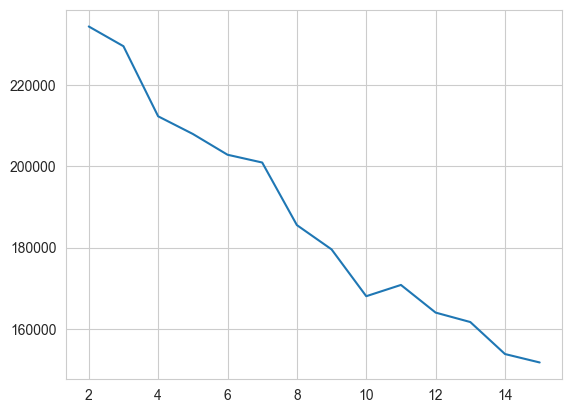

In [198]:
import matplotlib.pyplot as plt

plt.Figure(figsize=(10, 6))
plt.plot(valores_K, WSS)



En este caso, el codo se ve claramente en 10 clusters, coincide también con el coeficiente de silueta (SC) más alto, por lo que nos quedamos con 10.

In [199]:
K = 10

kmeans = KMeans(n_clusters = K, random_state = 42)
clusters = kmeans.fit_predict(X_norm_as)

# Creamos una columna con el índice del cluster
df_as_limpio['cluster'] = clusters
df_as_limpio.head(30)


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Model_3 Series,Model_5 Series,Model_7 Series,Model_M3,Model_M5,...,Color_White,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Sales_Classification_High,Sales_Classification_Low,cluster
0,2016,3.5,151748,98740,8300,False,True,False,False,False,...,False,False,False,False,True,False,True,True,False,8
7,2014,1.6,121156,102778,632,False,False,False,False,True,...,False,True,False,False,False,True,False,False,True,1
14,2017,1.6,107918,34078,7291,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,9
16,2013,2.6,110142,114844,5561,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,5
26,2015,2.0,41514,116902,8897,False,False,False,True,False,...,False,False,False,True,False,False,True,True,False,1
28,2021,3.0,105162,32076,9469,False,False,False,False,True,...,False,False,False,True,False,True,False,True,False,1
29,2014,3.8,90282,64049,1440,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,1
32,2019,2.1,97294,53277,4091,False,False,False,False,True,...,False,True,False,False,False,False,True,False,True,1
33,2015,2.4,194395,118788,3384,False,False,False,False,False,...,True,False,False,True,False,True,False,False,True,7
47,2024,3.7,157789,86855,648,False,True,False,False,False,...,False,False,True,False,False,False,True,False,True,8


Deshacemos los dummies creados y volvemos al formato de tabla original

In [200]:
df_as_limpio_nodummies = df_as_limpio.copy()

cols_model = [c for c in df_as_limpio_nodummies if c.startswith('Model_')]
df_as_limpio_nodummies['Model'] = df_as_limpio_nodummies[cols_model].idxmax(axis=1).str.replace('Model_', '')
df_as_limpio_nodummies = df_as_limpio_nodummies.drop(cols_model, axis=1)

cols_color = [c for c in df_as_limpio_nodummies if c.startswith('Color')]
df_as_limpio_nodummies['Color'] = df_as_limpio_nodummies[cols_color].idxmax(axis=1).str.replace('Color_', '')
df_as_limpio_nodummies = df_as_limpio_nodummies.drop(cols_color, axis=1)

cols_fuel = [c for c in df_as_limpio_nodummies if c.startswith('Fuel_Type_')]
df_as_limpio_nodummies['Fuel_Type'] = df_as_limpio_nodummies[cols_fuel].idxmax(axis=1).str.replace('Fuel_Type_', '')
df_as_limpio_nodummies = df_as_limpio_nodummies.drop(cols_fuel, axis=1)

cols_transmission = [c for c in df_as_limpio_nodummies if c.startswith('Transmission_')]
df_as_limpio_nodummies['Transmission'] = df_as_limpio_nodummies[cols_transmission].idxmax(axis=1).str.replace('Transmission_', '')
df_as_limpio_nodummies = df_as_limpio_nodummies.drop(cols_transmission, axis=1)

cols_sales = [c for c in df_as_limpio_nodummies if c.startswith('Sales_Classification_')]
df_as_limpio_nodummies['Sales_Classification'] = df_as_limpio_nodummies[cols_sales].idxmax(axis=1).str.replace('Sales_Classification_', '')
df_as_limpio_nodummies = df_as_limpio_nodummies.drop(cols_sales, axis=1)

df_as_limpio_nodummies.shape
df_as_limpio_nodummies.head(15)

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,cluster,Model,Color,Fuel_Type,Transmission,Sales_Classification
0,2016,3.5,151748,98740,8300,8,5 Series,Red,Petrol,Manual,High
7,2014,1.6,121156,102778,632,1,M5,Black,Diesel,Automatic,Low
14,2017,1.6,107918,34078,7291,9,X1,Black,Electric,Automatic,High
16,2013,2.6,110142,114844,5561,5,X5,Blue,Electric,Manual,Low
26,2015,2.0,41514,116902,8897,1,M3,Red,Hybrid,Manual,High
28,2021,3.0,105162,32076,9469,1,M5,Red,Hybrid,Automatic,High
29,2014,3.8,90282,64049,1440,1,M3,White,Electric,Automatic,Low
32,2019,2.1,97294,53277,4091,1,M5,Red,Diesel,Manual,Low
33,2015,2.4,194395,118788,3384,7,i8,White,Hybrid,Automatic,Low
47,2024,3.7,157789,86855,648,8,5 Series,Blue,Electric,Manual,Low


Vamos a sacar cocnclusiones y datos de cada cluster. También hago un conteo de filas para verificar que no he machacado el df.

In [201]:

df_as_limpio_nodummies['cluster'] = kmeans.labels_ 

#Comprobacion de que no estoy mezclando dataframes
suma = []

for n in range(kmeans.n_clusters):
    print(f'\n=== PERFIL DEL CLUSTER {n} ===')
    cluster = df_as_limpio_nodummies[df_as_limpio_nodummies.cluster == n]
    
    print(f"Número de coches: {len(cluster)}")
    suma.append(len(cluster))
    print(f"Precio promedio: ${cluster.Price_USD.mean():.0f}")
    print(f"Año promedio: {int(cluster.Year.mean())}")
    
    
    print(f"Modelo predominante: {cluster.Model.mode()[0]}")
    print(f"Combustible más frecuente: {cluster.Fuel_Type.mode()[0]}")
    print(f"Transmisión más frecuente: {cluster.Transmission.mode()[0]}")
    print("-" * 30)

print(f"Suma de coches en clusters: {sum(suma)}")


=== PERFIL DEL CLUSTER 0 ===
Número de coches: 731
Precio promedio: $76198
Año promedio: 2016
Modelo predominante: i3
Combustible más frecuente: Diesel
Transmisión más frecuente: Automatic
------------------------------

=== PERFIL DEL CLUSTER 1 ===
Número de coches: 1518
Precio promedio: $75514
Año promedio: 2016
Modelo predominante: M3
Combustible más frecuente: Hybrid
Transmisión más frecuente: Manual
------------------------------

=== PERFIL DEL CLUSTER 2 ===
Número de coches: 762
Precio promedio: $76101
Año promedio: 2017
Modelo predominante: 3 Series
Combustible más frecuente: Hybrid
Transmisión más frecuente: Automatic
------------------------------

=== PERFIL DEL CLUSTER 3 ===
Número de coches: 741
Precio promedio: $75439
Año promedio: 2017
Modelo predominante: X6
Combustible más frecuente: Electric
Transmisión más frecuente: Manual
------------------------------

=== PERFIL DEL CLUSTER 4 ===
Número de coches: 735
Precio promedio: $76704
Año promedio: 2017
Modelo predominant

Se aprecia factores comunes en todos los clusters, como el año (2016/2017), y el precio (alrededor de 75000$).

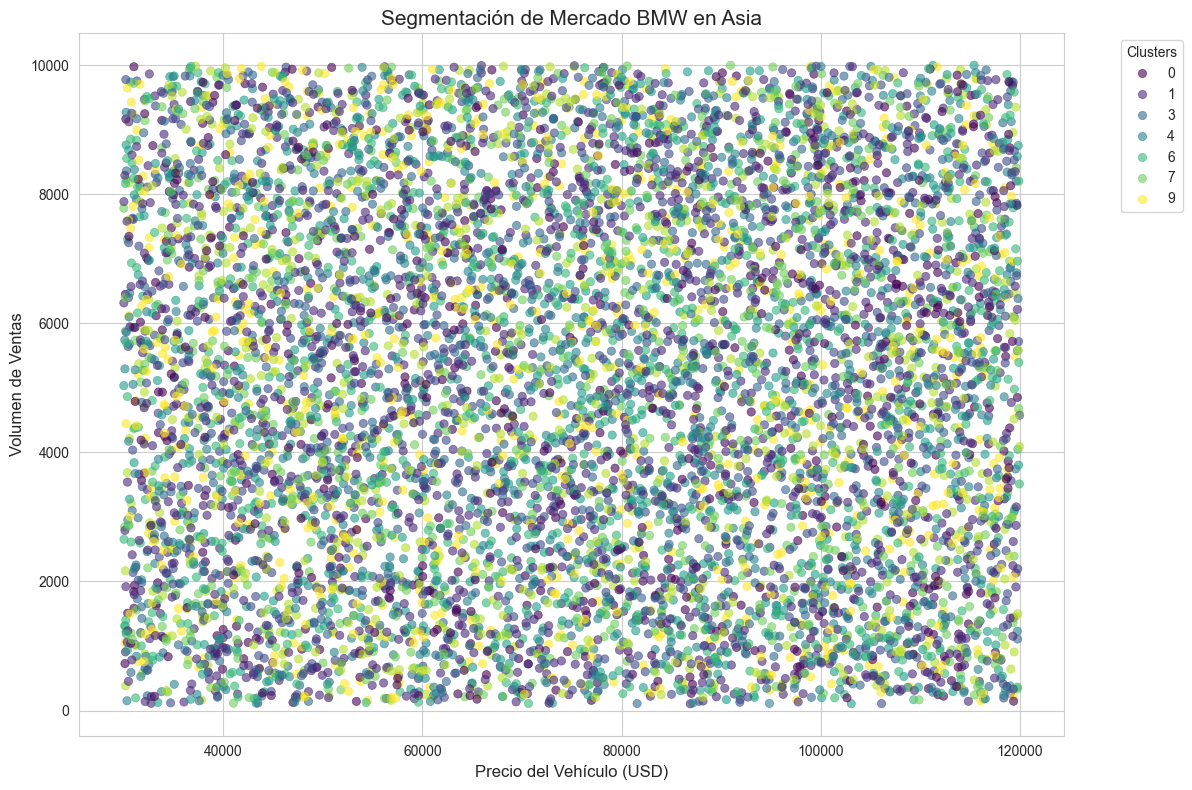

In [202]:
import seaborn as sns


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")


scatter = sns.scatterplot(
    data=df_as_limpio_nodummies, 
    x='Price_USD', 
    y='Sales_Volume', 
    hue='cluster',     # Colorear por cluster
    palette='viridis', # Gama de colores profesional
    alpha=0.6,         # Transparencia para ver dónde hay más densidad
    edgecolor=None
)

plt.title('Segmentación de Mercado BMW en Asia', fontsize=15)
plt.xlabel('Precio del Vehículo (USD)', fontsize=12)
plt.ylabel('Volumen de Ventas', fontsize=12)

# leyenda fuera para que no estorbe
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

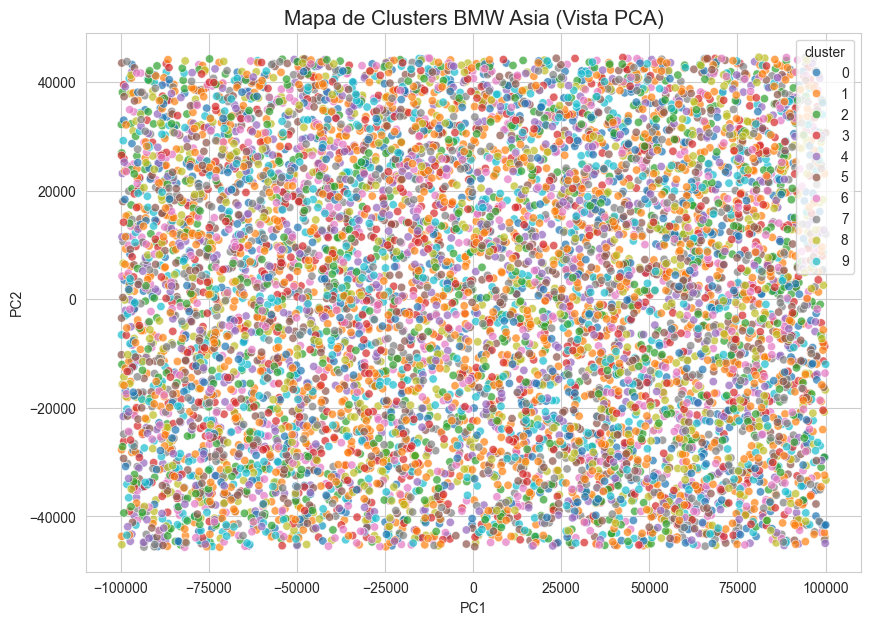

Varianza explicada por cada componente: [0.83119095 0.16678325]
Varianza total explicada (2 componentes): 99.80%


In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

pca_data = pca.fit_transform(df_as_limpio) 


df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = kmeans.labels_


plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='tab10', alpha=0.7)
plt.title('Mapa de Clusters BMW Asia (Vista PCA)', fontsize=15)
plt.show()

# Varianza explicada por cada componente
varianza = pca.explained_variance_ratio_
print(f"Varianza explicada por cada componente: {varianza}")
print(f"Varianza total explicada (2 componentes): {varianza.sum() * 100:.2f}%")

# La conclusión que puedo sacar es que el mercado asiatico es muy competitivo en todas sus opciones y que se han detectado 10 micro segmentos que destacan (los 10 crusters)